# This notebook was used to collect the datasets used in the analysis notebooks.

### Import

In [1]:
import numpy as np
import pandas as pd
import sys
from datetime import timedelta
import matplotlib.pyplot as plt
import requests
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler

### Data Pipeline:
1. Read and Clean Data
2. Detect Peaks (Local Maxima)
   1. Made Use of code located at bottom of notebook
3. Match Peaks with Peaks on Down Stream River.
   1. Most Likely do this with np.correlate.
4. Extract Attributes and Move to Dataset.
5. Perform Regression Methods on Dataset to learn params.

### HELPERS

In [2]:
def grab_river_data(url, name):
    file_name = "%s.txt" % name
    resp = requests.get(url)
    with open(file_name, 'w') as f:
        f.write(resp.text)
        
    df = pd.read_csv(file_name, delimiter='\t', usecols=[2,4], names=['time', 'discharge'], header=1, comment='#')
    return df

In [3]:
def read_usgs_data(filename):
    return pd.read_csv(file_name, delimiter='\t', usecols=[2,4], names=['time', 'discharge'], header=1, comment='#')

### Reading in data

In [5]:
freemont = grab_river_data('https://nwis.waterdata.usgs.gov/usa/nwis/uv/?cb_00060=on&format=rdb&site_no=09330000&period=&begin_date=2000-02-01&end_date=2018-02-19', 'freemont')
freemont.time = pd.to_datetime(freemont.time)

In [6]:
dirty_devil = grab_river_data('https://nwis.waterdata.usgs.gov/usa/nwis/uv/?cb_00060=on&format=rdb&site_no=09333500&period=&begin_date=2000-02-01&end_date=2018-02-19', 'dirty_devil')
dirty_devil.time = pd.to_datetime(dirty_devil.time)

### Creating Dataframe to store points.

In [229]:
free_dd_dataset = pd.DataFrame(columns=['free_time', 'free_discharge', 'dd_time', 'dd_discharge', 'secs_elapsed'])
free_dd_dataset.free_time = free_dd_dataset.free_time.astype('datetime64[ns]')
free_dd_dataset.free_discharge = free_dd_dataset.free_discharge.astype('float64')
free_dd_dataset.dd_time = free_dd_dataset.dd_time.astype('datetime64[ns]')
free_dd_dataset.dd_discharge = free_dd_dataset.dd_discharge.astype('float64')
free_dd_dataset.secs_elapsed = free_dd_dataset.secs_elapsed.astype('float64')

In [233]:
free_dd_dataset = pd.read_csv('datasets/freemont_dd_20180409-184220', index_col=False)

In [236]:
free_dd_dataset

,free_time,free_discharge,dd_time,dd_discharge,secs_elapsed,possible_outlier
0,2011-04-02 17:15:00,188.0,2011-04-04 17:45:00,237.0,174600.0,False
1,2011-04-03 14:45:00,501.0,2011-04-05 07:00:00,466.0,144900.0,False
2,2011-04-04 09:45:00,334.0,2011-04-05 20:30:00,354.0,125100.0,False
3,2011-04-05 13:30:00,186.0,2011-04-06 10:30:00,317.0,75600.0,True
4,2011-04-06 15:15:00,227.0,2011-04-08 15:15:00,271.0,172800.0,False
5,2011-04-07 12:15:00,188.0,2011-04-09 13:30:00,207.0,177300.0,False
6,2011-04-08 15:45:00,111.0,2011-04-10 20:30:00,155.0,189900.0,False


### Data Exploration 

In [52]:
len(freemont), len(dirty_devil)

(601392, 402733)

In [53]:
dirty_devil.dtypes

time         datetime64[ns]
discharge           float64
dtype: object

# Comparision Cell

In [1154]:
start_dt = pd.to_datetime('2005-12-01')
end_dt =  pd.to_datetime('2006-01-01')

In [1155]:
def get_std_scale(df):
    df_mean = df.discharge.mean()
    df_std = df.discharge.std()
    return (df.discharge.values - df_mean)/df_std

In [1156]:
riv1_good_ex = freemont[freemont.time.between(start_dt, end_dt)]
riv1_s = get_std_scale(riv1_good_ex)

In [1157]:
riv2_good_ex = dirty_devil[dirty_devil.time.between(start_dt, end_dt)]
riv2_s = get_std_scale(riv2_good_ex)

In [1158]:
len(riv1_good_ex), len(riv2_good_ex)

(2305, 576)

### Initial Plots to find good patterns

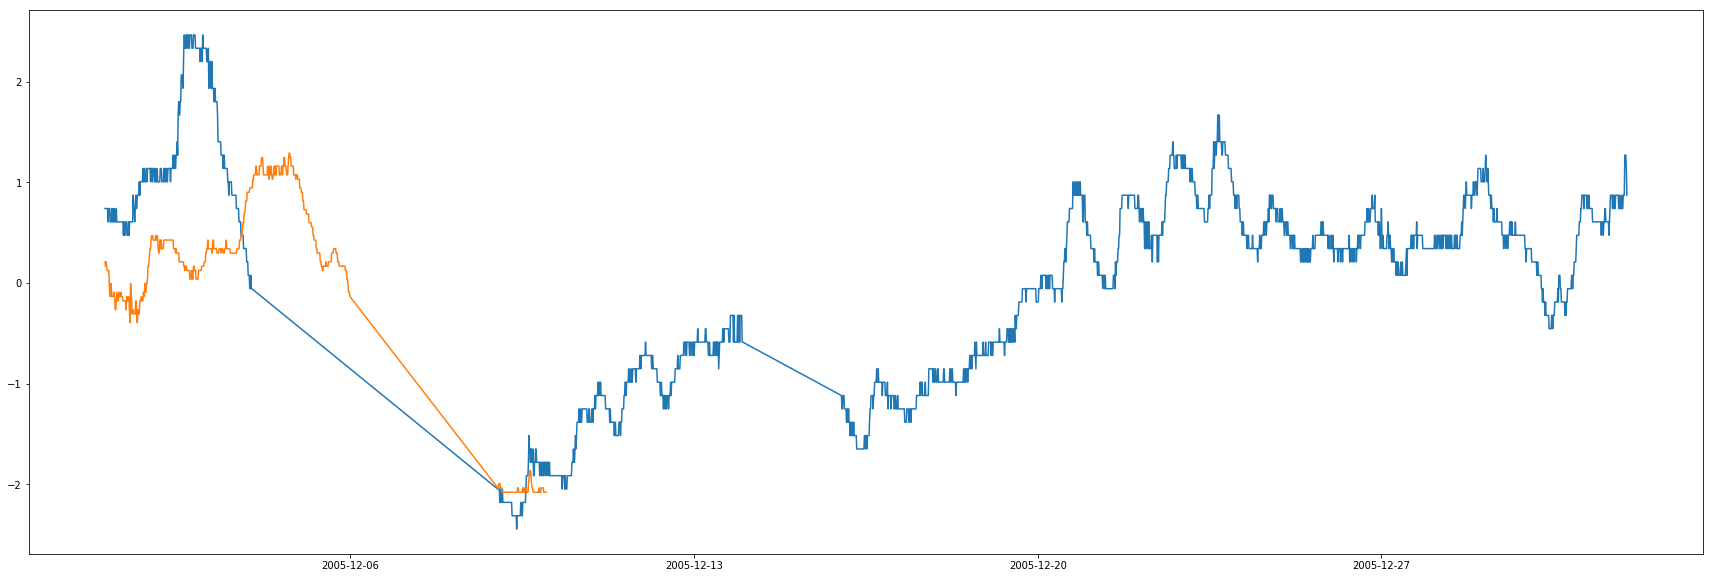

In [1162]:
plt.figure(figsize=(30,10))
plt.plot(riv1_good_ex.time, riv1_s)
plt.plot(riv2_good_ex.time, riv2_s)

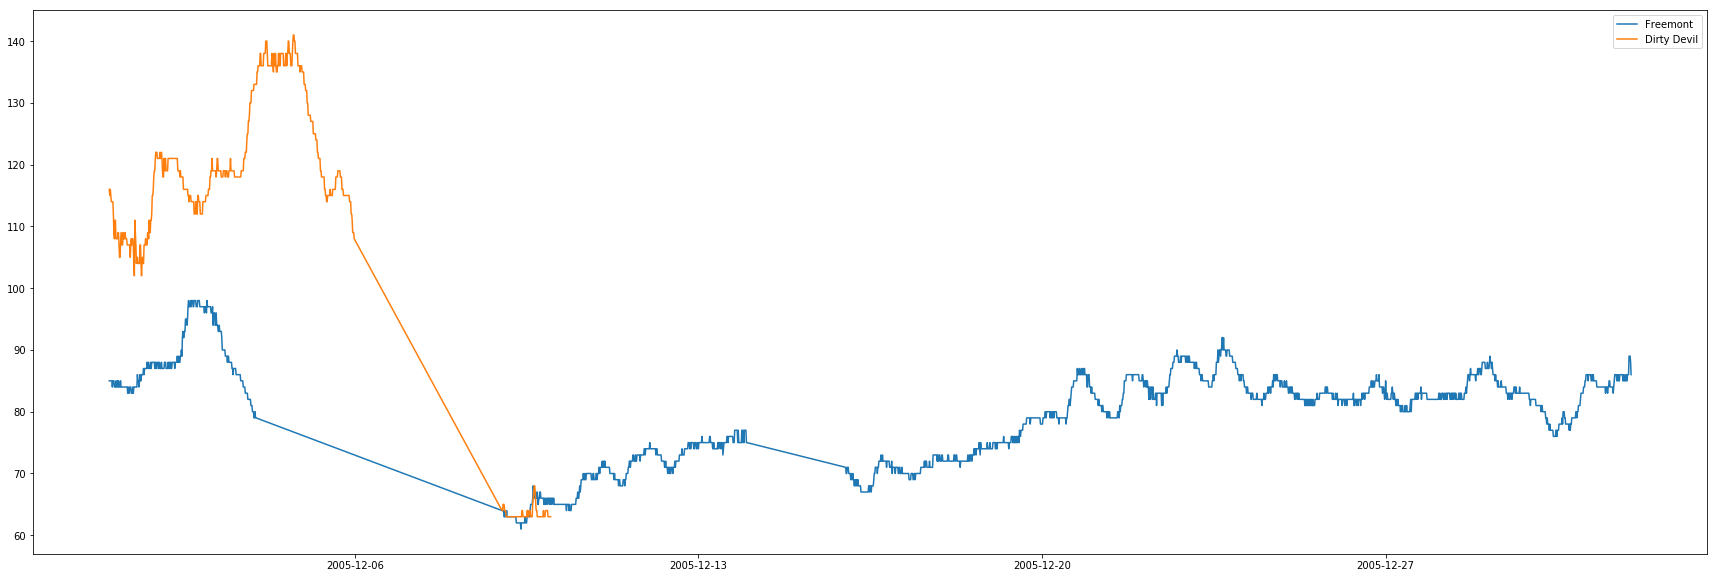

In [1163]:
plt.figure(figsize=(30,10))
plt.plot(riv1_good_ex.time, riv1_good_ex.discharge, label='Freemont')
plt.plot(riv2_good_ex.time, riv2_good_ex.discharge, label='Dirty Devil')
plt.legend()

#### Peak detection after finding good values

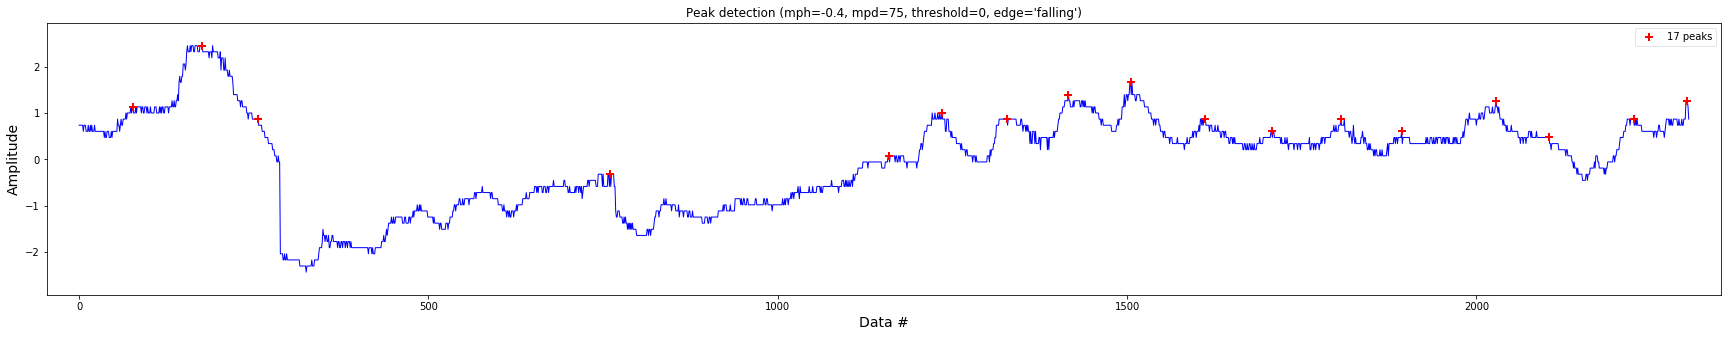

[  77  176  256  760 1159 1235 1328 1416 1505 1612 1707 1806 1893 2028
 2104 2225 2302]


In [1164]:
peak_riv_1 = detect_peaks(riv1_s, mph=-0.4, mpd=75, edge='falling', show=True)
print(peak_riv_1)

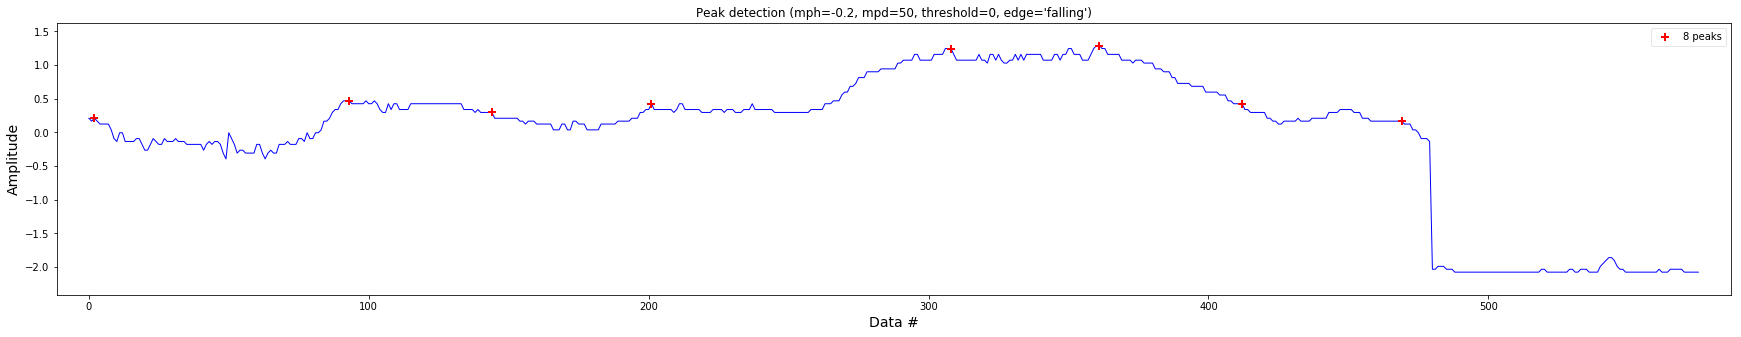

[  2  93 144 201 308 361 412 469]


In [1165]:
peak_riv_2 = detect_peaks(riv2_s, mph=-0.2, mpd=50, edge='falling', show=True)
print(peak_riv_2)

In [1103]:
riv1_ix = 2
riv2_ix = 5
actual_riv1_ix = peak_riv_1[riv1_ix] 
actual_riv2_ix = peak_riv_2[riv2_ix]
peak_riv_2[riv2_ix] - peak_riv_1[riv1_ix] 

109

In [1104]:
freemont_peak = riv1_good_ex.iloc[actual_riv1_ix]

In [1105]:
freemont_peak

time         2005-06-03 15:00:00
discharge                     93
Name: 171221, dtype: object

In [1106]:
dd_peak = riv2_good_ex.iloc[actual_riv2_ix]

In [1107]:
dd_peak

time         2005-06-04 18:15:00
discharge                   2460
Name: 61593, dtype: object

In [1108]:
time_diff = (dd_peak.time - freemont_peak.time).total_seconds()
(dd_peak.time - freemont_peak.time).total_seconds()

98100.0

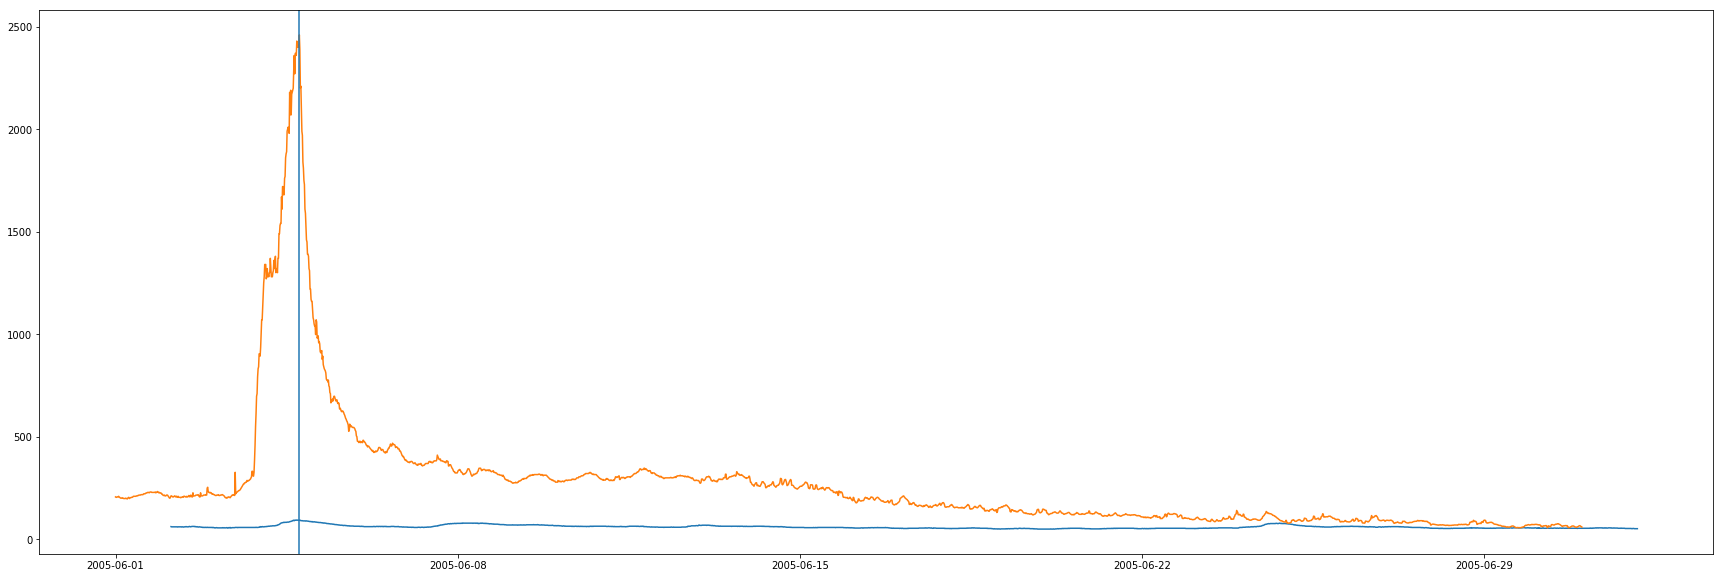

In [1109]:
plt.figure(figsize=(30,10))
plt.plot(riv1_good_ex.time + pd.DateOffset(seconds=time_diff), riv1_good_ex.discharge)
plt.plot(riv2_good_ex.time, riv2_good_ex.discharge)
plt.axvline(dd_peak.time)

# Sotri

In [1116]:
new_row = getStorableData(actual_riv1_ix, actual_riv2_ix, False)
new_row

[Timestamp('2005-06-03 15:00:00'),
 93.0,
 Timestamp('2005-06-04 18:15:00'),
 2460.0,
 98100.0,
 False]

In [1117]:
free_dd_dataset.loc[len(free_dd_dataset)+1] = new_row

In [1256]:
len(free_dd_dataset)

33

# PLOTTING DATASET

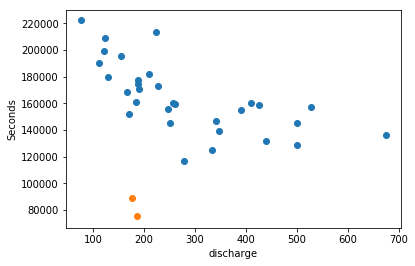

In [1260]:
non_outliers = free_dd_dataset[free_dd_dataset['possible_outlier'] == False]
outliers = free_dd_dataset[free_dd_dataset['possible_outlier'] == True]

plt.figure('GOOD GRAPH')
plt.xlabel('discharge')
plt.ylabel('Seconds')
plt.scatter(non_outliers.free_discharge, non_outliers.secs_elapsed)
plt.scatter(outliers.free_discharge, outliers.secs_elapsed)

In [1167]:
free_dd_dataset_copy = free_dd_dataset.copy()

In [1180]:
import datetime
free_dd_dataset.to_csv('datasets/freemont_2000-2005_dd_{}.csv'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

In [221]:
def getStorableData(index1, index2, outlier=False):
    riv1_peak_data=riv1_good_ex.iloc[index1]    #get river one peak date
    riv2_peak_data=riv2_good_ex.iloc[index2]
    timeDif=(riv2_peak_data.time-riv1_peak_data.time).total_seconds()
    return [riv1_peak_data.time, riv1_peak_data.discharge, riv2_peak_data.time, riv2_peak_data.discharge, timeDif, outlier] #get river two peak date

Possible Attributes  
X:
1. Upper River Discharge
2. Upper Rivers STD's Off Mean
3. Miles Between Meters if we decide to bring in more rivers.
4. Lower River Discharge
4. Lower River STD's Off Mean


Y:  
1. Number of 15 Min Date Offsets Between Anamoly Occurance

In [1241]:
# Create linear regression object
regr = linear_model.LinearRegression()
regr.fit(free_dd_dataset.free_discharge.values.reshape(-1,1), free_dd_dataset.secs_elapsed.values.reshape(-1,1))
preds = regr.predict(np.arange(0,700).reshape(-1,1))

yeets = np.polyfit(free_dd_dataset.free_discharge.values, free_dd_dataset.secs_elapsed.values, 3)
p_reg = np.poly1d(yeets)
plt.plot(p_reg(np.arange(0,700)))
plt.plot(preds)

Types of Models:
1. Simple Linear Regression
2. Multivariate Linear Regression
3. Polynomial Regression
4. Regression with regulizers

Use this cell to compare two rivers. Make sure the dataframe has a time, and discharge attribute. Also make sure that the time attribute is a datetime object, and the discharge attribute is a number type. You can specify the number of standard deviations away the change at that time was from the average to calculate what locations are looked at. YOu can also change the number of days before and after the anamoly to show.

In [168]:
"""Detect peaks in data based on their amplitude and other features."""

from __future__ import division, print_function
import numpy as np

__author__ = "Marcos Duarte, https://github.com/demotu/BMC"
__version__ = "1.0.4"
__license__ = "MIT"


def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    """Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height.
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`
    
    The function can handle NaN's 

    See this IPython Notebook [1]_.

    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)

    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=0, mpd=20, valley=True, show=True)

    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)

    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind


def _plot(x, mph, mpd, threshold, edge, valley, ax, ind):
    """Plot results of the detect_peaks function, see its help."""
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(30, 5))

        ax.plot(x, 'b', lw=1)
        if ind.size:
            label = 'valley' if valley else 'peak'
            label = label + 's' if ind.size > 1 else label
            ax.plot(ind, x[ind], '+', mfc=None, mec='r', mew=2, ms=8,
                    label='%d %s' % (ind.size, label))
            ax.legend(loc='best', framealpha=.5, numpoints=1)
        ax.set_xlim(-.02*x.size, x.size*1.02-1)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax.set_xlabel('Data #', fontsize=14)
        ax.set_ylabel('Amplitude', fontsize=14)
        mode = 'Valley detection' if valley else 'Peak detection'
        ax.set_title("%s (mph=%s, mpd=%d, threshold=%s, edge='%s')"
                     % (mode, str(mph), mpd, str(threshold), edge))
        # plt.grid()
        plt.show()